# A D3 Viewer for Matplotlib Visualizations

*This notebook originally appeared as a*
[*blog post*](http://jakevdp.github.io/blog/2013/12/19/a-d3-viewer-for-matplotlib/)
*by Jake Vanderplas on*
[*Pythonic Perambulations*](http://jakevdp.github.io/).
*Content is BSD licensed*

**Update, March 2014: there are some major changes and refactorings in mpld3 version 0.1.
Because of this, some of the code below will not work with the current release: please
see the [mpld3 documentation](http://mpld3.github.io) for more information.**

<!-- PELICAN_BEGIN_SUMMARY -->

I've spent a lot of time recently attempting to push the boundaries of tools for interactive data exploration within the IPython notebook.  I have worked on animations, including an [HTML5 embedding](http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/) and a [Javascript Viewer](http://jakevdp.github.io/blog/2013/05/19/a-javascript-viewer-for-matplotlib-animations/).  I have worked on [javascript/python kernel interaction](http://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/) and [static javascript widgets](http://jakevdp.github.io/blog/2013/12/05/static-interactive-widgets/).  But I would say that the holy grail of interactive data visualization in the IPython notebook is, as I've [mentioned previously](http://jakevdp.github.io/blog/2013/03/23/matplotlib-and-the-future-of-visualization-in-python/), a truly interactive in-browser matplotlib display.

There are many people pushing in this direction in the Python world. [Bokeh](http://continuum.io/blog/painless_streaming_plots_w_bokeh) and [Plotly](https://plot.ly/) are new visualization packages which have built Python APIs from scratch.  The demos are beautiful and impressive, and the APIs are clean and intuitive.  But, because matplotlib is so well-established in the Python world, it would be nice to be able to continue using it even in the age of browser-based visualization. To this end, some of the matplotlib core devs have been working on a [WebGL viewer](http://mdboom.github.io/blog/2012/10/11/matplotlib-in-the-browser-its-coming/) for matplotlib figures.  I've seen a working demo, and it's very cool, but last I heard it still has a long way to go.

I've been wondering for a while whether it might be possible to create a solution using D3.js.  D3 (short for [data-driven documents](http://d3js.org/)) is a framework which facilitates the easy creation and manipulation of groups of HTML objects.  Combined with the native SVG support of modern web browsers, it provides an extremely powerful and flexible low-level interface to creating interactive graphics on the web.  I've long wondered what it would take to write a D3 backend or frontend for matplotlib, but I'd never experimented with the idea. It was a couple weeks ago at [Seattle Beer && Code](http://seattle.beerandcode.org/) meetup that I chatted with some expert Javascript hackers who pointed out where I might start.

I started to try things out, and over the course of a few late nights, came up with a first attempt at a partial interactive D3 viewer for matplotlib images: the result is the ``mpld3`` package, available on [my GitHub page](http://github.com/jakevdp/mpld3).  

<!-- PELICAN_END_SUMMARY -->

## A First Demo: ``mpld3``

The usage of ``mpld3`` is extremely simple: with it, we can simply create a matplotlib plot, call ``display_d3``, and get an interactive result rendered using D3!  Here's a quick example: be sure to try panning and zooming the plot with your mouse.

In [1]:
#%matplotlib inline
import mpld3
import numpy as np
from matplotlib import pyplot as plt # for plots
#from mpld3.display import display_d3

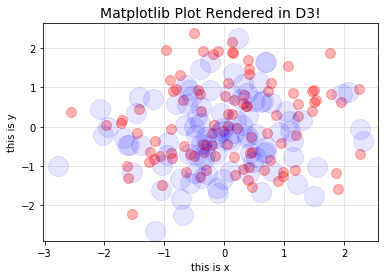

In [2]:
fig, ax = plt.subplots()
np.random.seed(0)
#x, y = np.random.normal(0,1,[2,100])

#fig = plt.figure()
#points = plt.scatter(x, y, alpha=0.3)
#plt.grid(color="lightgray");
ax.plot(np.random.normal(size=100),
        np.random.normal(size=100),
        'or', ms=10, alpha=0.3)
ax.plot(np.random.normal(size=100),
        np.random.normal(size=100),
        'ob', ms=20, alpha=0.1)

ax.set_xlabel('this is x')
ax.set_ylabel('this is y')
ax.set_title('Matplotlib Plot Rendered in D3!', size=14)
ax.grid(color='lightgray', alpha=0.7)

mpld3.enable_notebook()
fig
#display_d3(fig)

## How it all works

So what exactly is the magic here?  We can take a look at what's going on under the hood by printing the html directly.  It's long, so we'll print just the first few lines:

In [3]:
import mpld3
html = mpld3.fig_to_html(fig)
print ('\n'.join(html.split('\n')[:50]))



<style>

</style>

<div id="fig_el746420418121271921912162890"></div>
<script>
function mpld3_load_lib(url, callback){
  var s = document.createElement('script');
  s.src = url;
  s.async = true;
  s.onreadystatechange = s.onload = callback;
  s.onerror = function(){console.warn("failed to load library " + url);};
  document.getElementsByTagName("head")[0].appendChild(s);
}

if(typeof(mpld3) !== "undefined" && mpld3._mpld3IsLoaded){
   // already loaded: just create the figure
   !function(mpld3){
       
       mpld3.draw_figure("fig_el746420418121271921912162890", {"width": 432.0, "height": 288.0, "axes": [{"bbox": [0.125, 0.125, 0.775, 0.755], "xlim": [-3.02641822913218, 2.5577421703894716], "ylim": [-2.911288088639775, 2.635260625506976], "xdomain": [-3.02641822913218, 2.5577421703894716], "ydomain": [-2.911288088639775, 2.635260625506976], "xscale": "linear", "yscale": "linear", "axes": [{"position": "bottom", "nticks": 8, "tickvalues": null, "tickformat": null, "scale": "linear

You can download this notebook and print the full HTML to see more.

The essential idea is this: matplotlib has a well-defined API with an [abstract object structure](http://matplotlib.org/api/index.html) which is rendered to different formats (interactive displays, pdf, png, etc.) through specialized backends.  What I've done here is create a function which digs into the object structure of a matplotlib figure, sniffs out relevant information, and translates it into D3-powered vector graphics.  Having never used D3 before this week, I based it all on examples I found online ([this](http://alignedleft.com/tutorials/d3/making-a-scatterplot), [that](http://jsfiddle.net/KSAbK/1/), [and](http://bl.ocks.org/weiglemc/6185069) [others](http://stackoverflow.com/questions/15069959/d3-js-scatter-plot-zoom-drag-boundaries-zoom-buttons-reset-zoom-calculate-m)), which were extremely helpful in the process.

Once that mapping of matplotlib object to D3-powered HTML/Javascript was complete, I tied the resulting HTML to the IPython's  [rich display](http://nbviewer.ipython.org/github/ipython/ipython/blob/master/examples/notebooks/Part%205%20-%20Rich%20Display%20System.ipynb) hook, and the result is what you see above.

## What's supported and what's not

To be entirely fair, I should point out now that if you're expecting to take this and render your favorite matplotlib plot out-of-the-box, you're probably in for a disappointment.  The package is currently a limited proof-of-concept which works for a few of matplotlib's features; I'm hoping to add others with time (or better yet, let other contributors add to the library), but as of this posting only the following is supported:

#### Currently Supported Features

- Defining figure sizes
- Adding axes of arbitrary extents (i.e. ``plt.axes()``, ``plt.subplot()``, etc.)
- Line plots with several plot styles (i.e. ``plt.plot()``)
- round-circle Scatter-plots via ``plt.plot()`` (**Not** via ``plt.scatter()``, which uses a different object layout)
- grids of various styles
- xlabels, ylabels, titles, and text

That's a small list out of a large number of features available.  Here are some of the future features to work on, to name a few:

#### Currently Unsupported Features

- patches (i.e. shapes like histograms, etc.)
- polygons (filled plots, etc.)
- collections (scatter plots, etc.)
- containers (errorbars, etc.)
- correct text placement and alignment
- images (e.g. ``plt.imshow()``)
- log axes and date axes
- everything else I didn't explicitly list above
- tick placement and formatting
- axes text (i.e. text whihc pans and zooms with the data)
- legends and plot labels

As you can see, there's a lot that's missing.  However, there's nothing fundamental keeping most of these from being added: it's just a matter of putting-in the coding hours.  I've tried to design the module so that it will be easy to extend; if you'd like to contribute, please take a look and try it out!  And, if you're reading this much past December 2013, I (and others) will hopefully have done some more work and implemented some more features.  Be sure to check the [github repository](http://github.com/jakevdp/mpld3/) for updates.

## More Examples

The details out of the way, we can now take a look at a few more examples of what is possible here.  You'll see the lines, points, grids, and labels that are made possible in the current version of ``mpld3``.  In each case, note the fact that we're not using any markup beyond the standard matplotlib syntax.  Throughout, I've tried to capture the relevant metadata and pass it on to the HTML-rendered plot:

### Multiple Lines

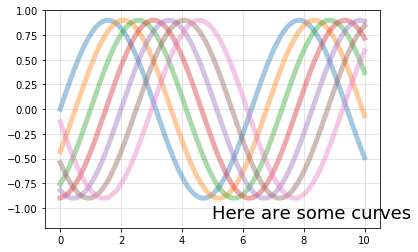

In [4]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
for offset in np.linspace(0, 3, 7):
    ax.plot(x, 0.9 * np.sin(x - offset), lw=5, alpha=0.4)
ax.set_ylim(-1.2, 1.0)
ax.text(5, -1.1, "Here are some curves", size=18)
ax.grid(color='lightgray', alpha=0.7)

mpld3.enable_notebook()
fig
#display_d3(fig)

### Dots and Points

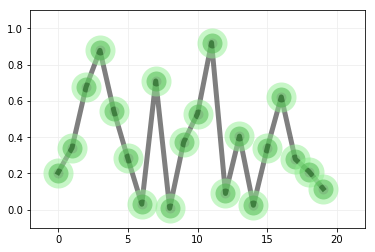

In [5]:
fig, ax = plt.subplots()
ax.plot(np.random.rand(20), '-o', alpha=0.5,
        color='black', linewidth=5,
        markerfacecolor='green',
        markeredgecolor='lightgreen',
        markersize=20,
        markeredgewidth=10)
ax.grid(True, color='#EEEEEE', linestyle='solid')
ax.set_xlim(-2, 22)
ax.set_ylim(-0.1, 1.1)
#display_d3(fig)
mpld3.enable_notebook()
fig

### Moving Window Average

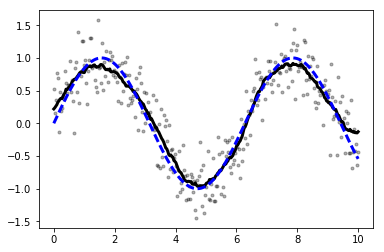

In [6]:
np.random.seed(0)
t = np.linspace(0, 10, 300)
x = np.sin(t)
dx = np.random.normal(0, 0.3, 300)

kernel = np.ones(25) / 25.
x_smooth = np.convolve(x + dx, kernel, mode='same')

fig, ax = plt.subplots()
ax.plot(t, x + dx, linestyle='', marker='o',
        color='black', markersize=3, alpha=0.3)
ax.plot(t, x_smooth, '-k', lw=3)
ax.plot(t, x, '--k', lw=3, color='blue')

#display_d3(fig)
#mpld3.enable_notebook()
fig

### Subplots

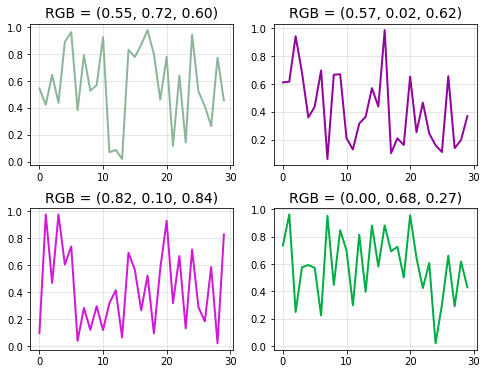

In [7]:
# multiple subplots, adjusted for spacing
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.3)

np.random.seed(0)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    color = np.random.random(3)
    ax.plot(np.random.random(30), lw=2, c=color)
    ax.set_title("RGB = ({0:.2f}, {1:.2f}, {2:.2f})".format(*color),
                 size=14)
    ax.grid(color='lightgray', alpha=0.7)
 
#mpld3.enable_notebook()
fig
#display_d3(fig)

## Conclusion

As I mentioned above, there is still a lot to be done to make this a truly useful tool for data exploration: right now, the list of usupported features alone likely dwarfs the size of the current code base! But as a proof-of-concept, I think this work is headed in the right direction.  I'm still not entirely convinced that a hacked approach like this should be preferred over a more bottom-up approach to interactive visualization, such as those being developed by the Bokeh and Plotly teams.  But if there's one thing I've learned in open source, it's that [afternoon hacks](http://vcresearch.berkeley.edu/news/wresting-new-tricks-python-fernando-perez-wins-2012-award-advancement-free-software), given time and talent, can turn into irreplaceable tools for scientific computing.  In the open, the truly useful hacks develop and evolve: all our most useful tools were started by someone, somewhere, who had a good idea and a bit of free time to try it out.  In open source work, we should never let the perfect be the enemy of the good.

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.com/downloads/notebooks/mpld3Demo.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.com/downloads/notebooks/mpld3Demo.ipynb).
</small>